In [ ]:
import sys
sys.path.append('../weather data')
from iastate_download import get_session, get_station_df

In [ ]:
from os.path import isfile
from shutil import copy2
from time import time

def write_station_df(sid : str, file_name, s):
    if isfile(file_name):
        print(f'{file_name} already exists')
        return ''

    start = time()
    station = get_station_df(sid, s)
    if station is None:
        print(f'Retrieve {sid} failed')
    else:
        print(f'Completed {sid} in {time() - start} seconds')
        station.to_parquet(file_name)
        return file_name


stations = {'IA' : ['CBF', 'IKV', 'CWI', 'VTI'],
            'MN' : ['DLH', 'JKJ', 'LYV', 'MSP', 'RST'], 
            'WI' : ['MSN', 'MKE', 'EAU', 'GRB'],
            'MI' : ['ANJ', 'GRR', 'LAN', 'DET', 'ARB'],
            'IN' : ['EVV', 'FWA', 'GYY', 'IND', 'SBN', 'SPI'],
            'IL' : ['BMI', 'CMI', 'ARR', 'PIA'],
            'MO' : ['STL', 'COU', 'SGF', 'MKC'],
            'MS' : ['HKS', 'MJD', 'TUP', 'MEI'],
            'LA' : ['BTR', 'LFT', 'LCH', 'SHV', 'AEX'],
            'TX' : ['LFK'] }
paths = []
with get_session() as s:
    for state in stations.keys():
        for station in stations[state]:
            station_dst = f'../data/weather/big_cities/{state}_{station}.parquet'
            paths.append(station_dst)
            if isfile(station_dst):
                continue
            station_src = f'../data/weather/stations/{station}_weather_data.parquet'

            already_downloaded = isfile(station_src)
            if already_downloaded:
                copy2(station_src, station_dst)
                continue
            station_src = f'../data/{state}_{station}_weather_data.parquet'
            already_downloaded = isfile(station_src)
            if already_downloaded:
                copy2(station_src, station_dst)
                continue
            write_station_df(station, station_dst, s)


In [43]:
from datetime import timedelta, timezone, datetime
import pandas as pd

def make_hourly(weather):
    try:
        weather = weather.drop_duplicates('valid').set_index('valid')
        start = datetime(2015,  1, 20,  0, tzinfo=timezone(timedelta(hours=-5)))
        stop  = datetime(2021, 12, 31, 23, tzinfo=timezone(timedelta(hours=-5)))
        dates = pd.date_range(start = start, end = stop)
        hours = [d.replace(hour = h) for d in dates for h in range(0, 23)]
        return weather.iloc[[weather.index.get_loc(d, method='nearest') for d in hours]]
    except Exception as e:
        print(f'Unable to normalize {weather.head(1)}')
        print(f'Error {e}')
        return None

In [44]:
weathers = [make_hourly(pd.read_parquet(w)) for w in paths]

In [100]:
renamed_weathers = []
start = datetime(2015,  1, 20,  0, tzinfo=timezone(timedelta(hours=-5)))
stop  = datetime(2021, 12, 31, 23, tzinfo=timezone(timedelta(hours=-5)))
dates = pd.date_range(start = start, end = stop)
hours = [d.replace(hour = h) for d in dates for h in range(0, 23)]

for w in weathers:
    station = w.iloc[0]['station']
    w = w[['tmpf', 'feel']]
    w = w.rename(columns={'tmpf':f"{station}_tmpf", 'feel':f"{station}_feel"})
    w.index = hours
    w.to_parquet(f'../data/weather/big_cities/slim/{station}.parquet')
    renamed_weathers.append(w)

In [101]:
merged = renamed_weathers[0]
for w in renamed_weathers[1:]:
    merged = merged.merge(w, left_index=True, right_index=True, how='inner')

In [112]:
merged2.to_parquet('../data/weather/big_cities/merged_feel.parquet')

In [110]:
merged2 = merged[[col for col in merged.columns if col.endswith('feel')]]

In [113]:
file_name = 'all_regional_mtlf_after_intg.parquet'
df = pd.read_parquet(f'../data/{file_name}')
target_range = df[(df['Market Day'] >= datetime(2015,1,20)) & (df['Market Day'] <= datetime(2021,12,31))]

In [115]:
targets = pd.DataFrame()

targets['MarketHour'] = target_range.apply(lambda x: x['Market Day'].replace( hour = x['HourEnding'] - 1, tzinfo = timezone(timedelta(hours=-5))), axis=1)
targets['Load'] = target_range['MISO ActualLoad (MWh)']
targets.set_index('MarketHour', inplace=True)

In [119]:
merged3 = merged2.merge(targets, left_index=True, right_index=True)

In [140]:
import numpy as np
features = [col for col in merged3.columns if col.endswith('feel')]
A = merged3[features]
A['b'] = np.ones(A.shape[0])
y = merged3['Load']
(x, rss, _, _) = np.linalg.lstsq(A, y)

/tmp/ipykernel_1821/3825873310.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  (x, rss, _, _) = np.linalg.lstsq(A, y)


In [123]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

In [141]:
yhat = np.inner(A, x)

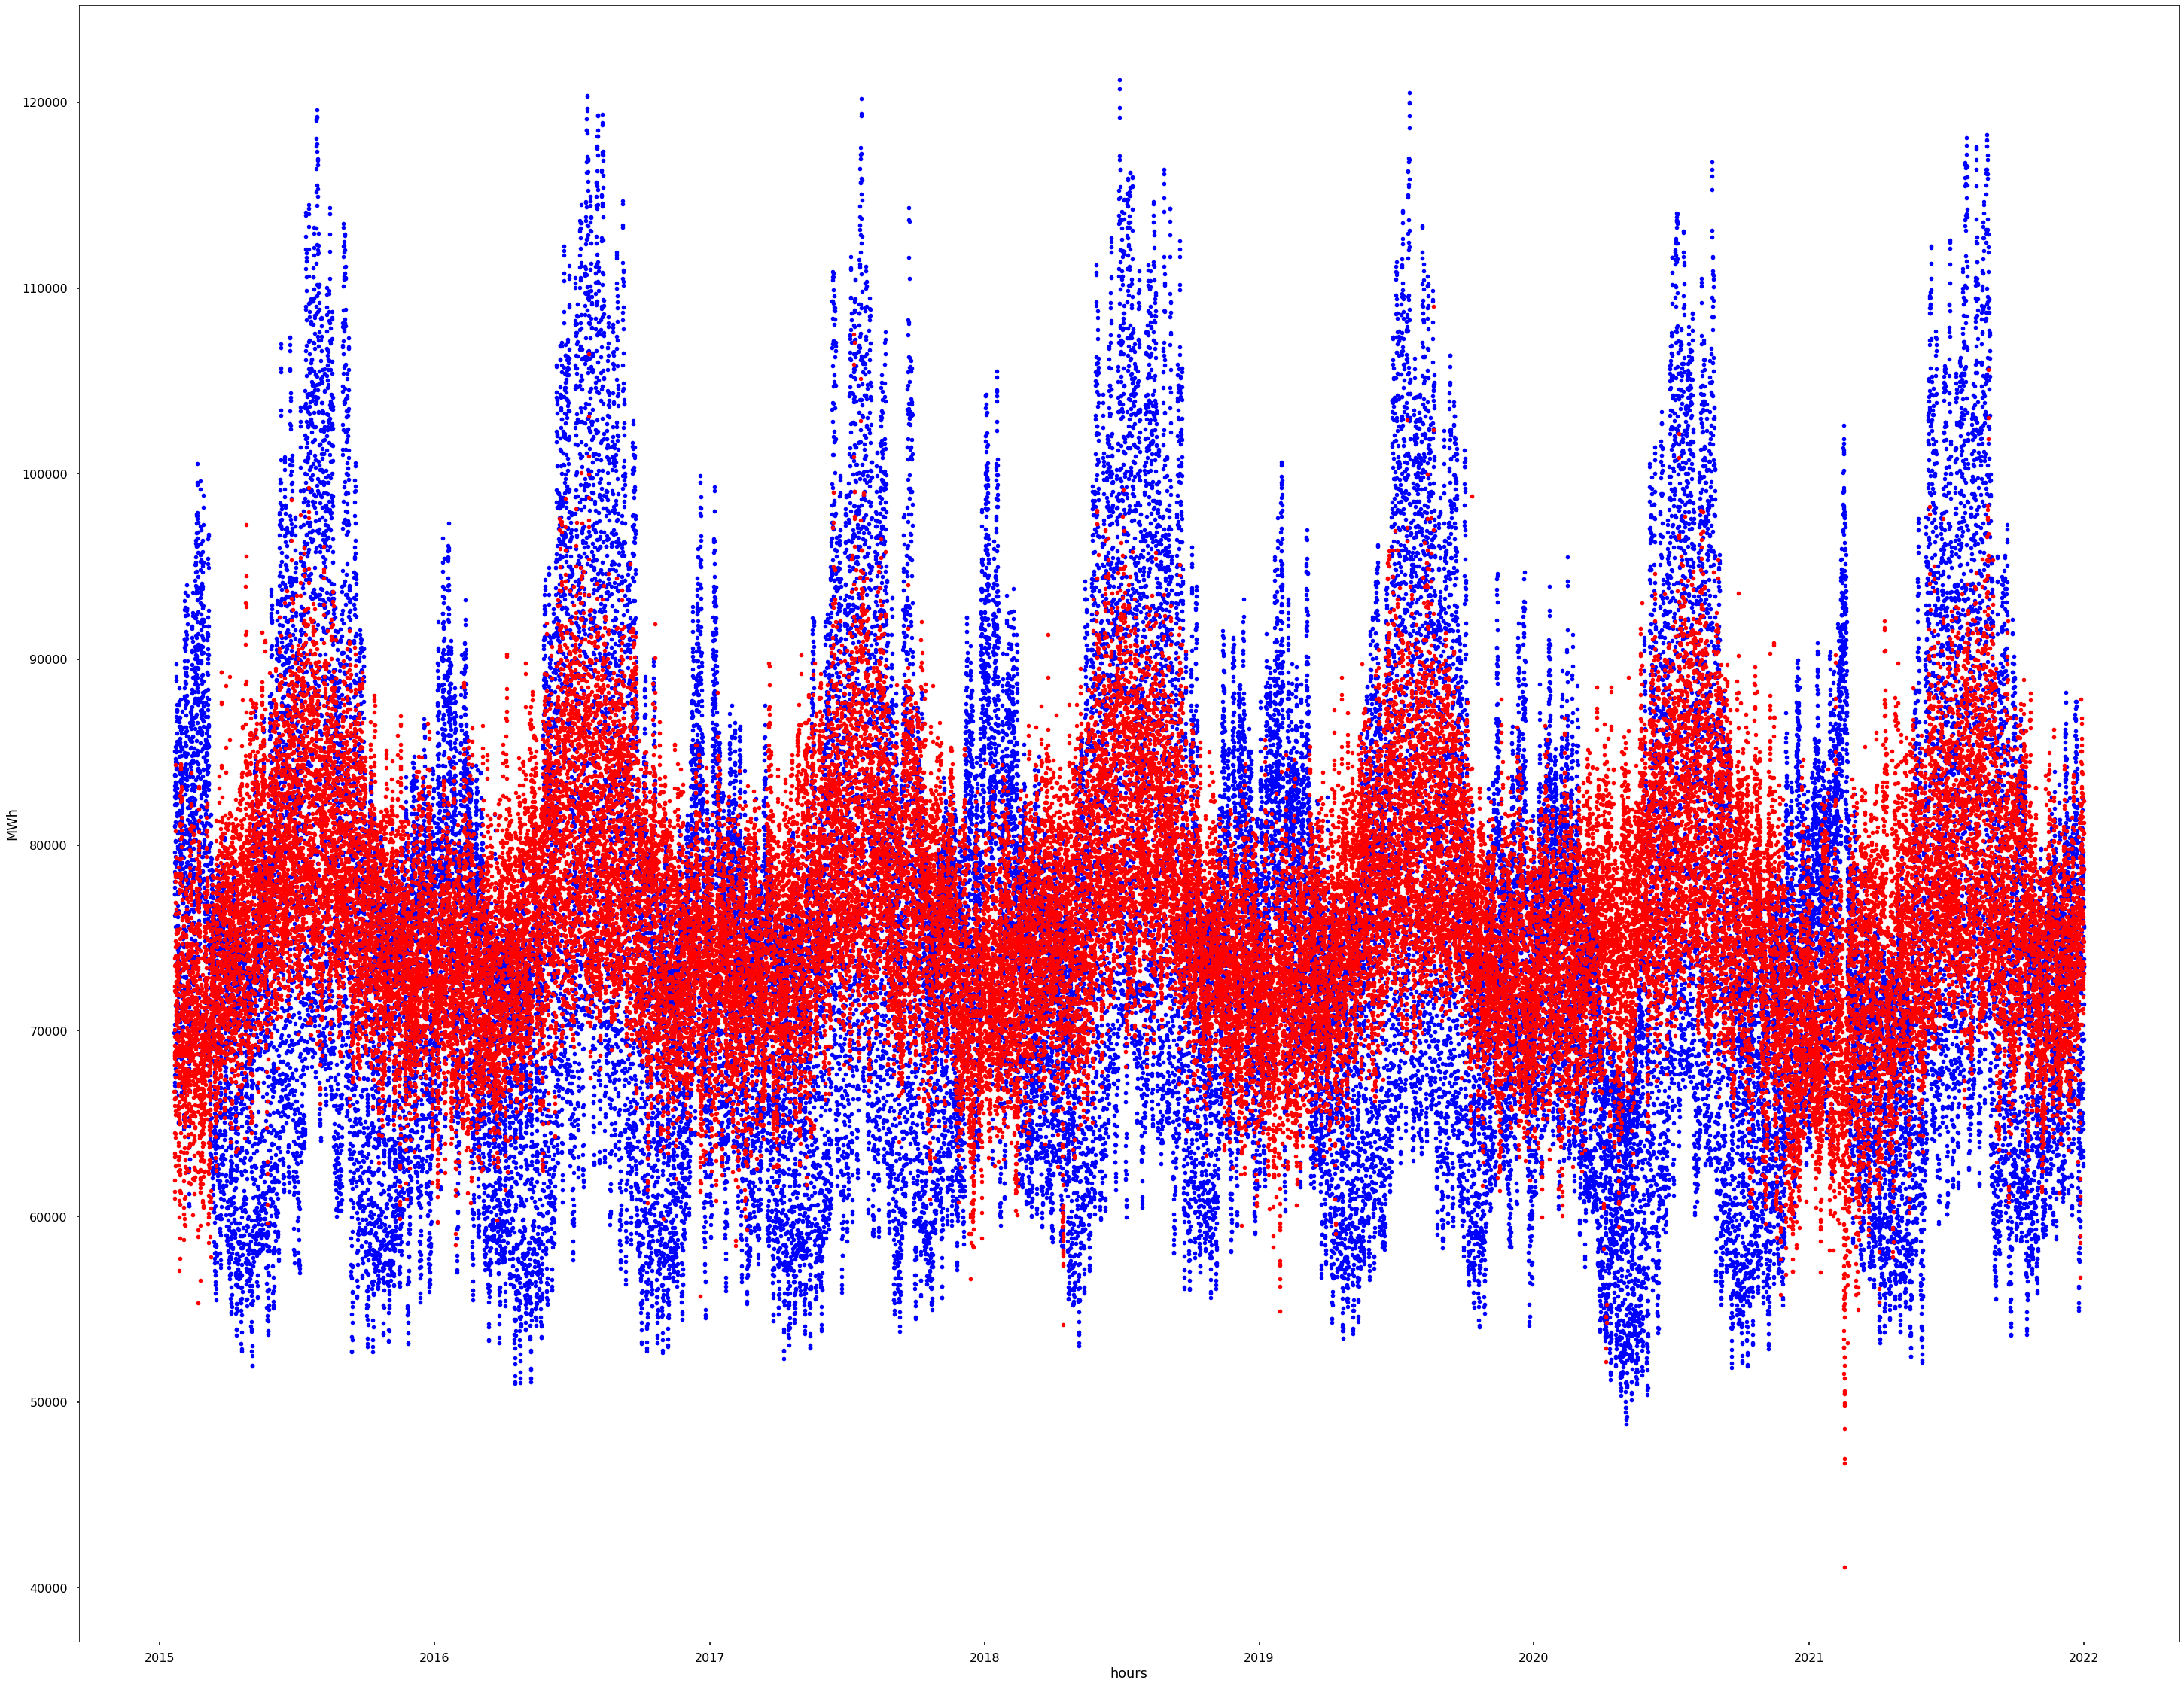

In [145]:
# plot the results
plt.figure(figsize = (50, 40))
plt.plot(hours, y, 'b.')
plt.plot(hours, yhat, 'r.')
plt.xlabel('hours')
plt.ylabel('MWh')
plt.show()